In [7]:
import scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression

# Banco de dados wheat: Espectros NIR de 100 amostras de FLOUR. Faixa de comprimento de onda de 1101 a 2502 nm com 2 nm de intervalo (701 preditores)

Respostas: moisture e protein
 
x0 - x700   = Absorbancias nos comprimentos de onda de 1101-2502 nm.

x702 - x703 = Matriz de respostas 

In [100]:
annots = loadmat('Datasets/wheat.mat')                  # Carregar o arquivo wheat.mat
df_wheat = pd.DataFrame(annots['wheat'])                # Transformar em um dataframe

df_wheat.sample(3)

,0,1,2,3,4,5,6,7,8,9,...,693,694,695,696,697,698,699,700,701,702
21,0.338895,0.338320,0.337689,0.337149,0.336694,0.336325,0.335979,0.335747,0.335722,0.335871,...,1.188043,1.189586,1.191194,1.191995,1.192848,1.194046,1.194022,1.194767,11.77,13.42
42,0.324872,0.324283,0.323625,0.323000,0.322465,0.322010,0.321541,0.321147,0.320835,0.320701,...,0.996889,0.998503,1.000170,1.001273,1.002322,1.002956,1.003353,1.003965,10.86,16.77
86,0.303480,0.302918,0.302296,0.301760,0.301262,0.300866,0.300488,0.300183,0.299965,0.299893,...,1.045599,1.047611,1.049176,1.050479,1.051330,1.051938,1.052562,1.053103,11.30,15.83


## Pré-processamento e normalização

In [101]:
X = df_wheat.iloc[:,:700].values                         # x0 - x700   = Absorbancias nos comprimentos de onda de 1101-2502 nm.
y1 = df_wheat.iloc[:,701].values                         # 701 = Moisture
y2 = df_wheat.iloc[:,702].values                         # 702 = Protein   
sc = RobustScaler()                                      # Instancia do robust scaler, para normalizar os dados - usa mediana e desvio padrão


# MOISTURE
#train_test spli - escolhido 25% como teste
X_train, X_test, y1_train, y1_test = train_test_split(
                                                    X, y1, 
                                                    test_size=0.25, 
                                                    random_state=42
                                                    )

# PROTEIN
#train_test spli - escolhido 25% como teste
X_train, X_test, y2_train, y2_test = train_test_split(
                                                    X, y2, 
                                                    test_size=0.25, 
                                                    random_state=42
                                                    )

X_train = sc.fit_transform(X_train)                     # Normalização dos dados de treino - fit
X_test = sc.transform(X_test)                           # Normalização dos dados de teste - transform apenas. Evita problemas de data leakage

# MOISTURE
y1_train = sc.fit_transform(y1_train.reshape(-1,1))     # Normalização dos dados de treino - fit
y1_test = sc.transform(y1_test.reshape(-1,1))           # Normalização dos dados de teste - transform apenas. Evita problemas de data leakage

# PROTEIN
y2_train = sc.fit_transform(y2_train.reshape(-1,1))     # Normalização dos dados de treino - fit
y2_test = sc.transform(y2_test.reshape(-1,1))           # Normalização dos dados de teste - transform apenas. Evita problemas de data leakage

## Teste das componentes para encontrar menor valor de erro

MSE mínimo: 0.22 foi atingido com n_components = 25 para a variável Moisture
R2 score da regressão com 25 componentes para a variável Moisture: 0.81


MSE mínimo: 0.00 foi atingido com n_components = 26 para a variável Proteína
R2 score da regressão com 26 componentes para a variável Proteína: 0.98


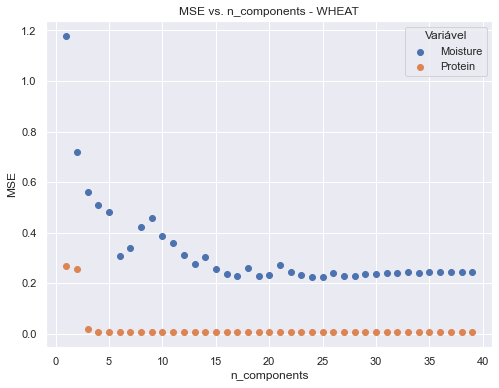

In [109]:
# muitos avisos de deprecação
import warnings
warnings.filterwarnings('ignore')

pls = [0]*100                                                     # Inicia vetor com PLS de 1 a 100 componentes
mse = [0]*100                                                     # Inicia vetor de erro para guardar cada um dos erros da regressão PLS


for n in range (1,100):                                           # Loop para calcular o erro para cada número de componentes

    pls[n] = PLSRegression(n_components=n)                        # Instancia o modelo PLS com n componentes
    pls[n].fit(X_train, y1_train)                                  # Faz a regressão
    mse[n] = mean_squared_error(y1_test, pls[n].predict(X_test))   # Calcula o erro   
mse[0] = mse[1]                                                   # tratamento para evitar o erro na hora de avaliar o mínimo MSE


sns.set(rc={'figure.figsize':(8,6)})                              # Define o tamanho e parâmetros da imagem
ax = plt.scatter(range(1,40), mse[1:40])                          # Plota o gráfico de erro
plt.title('MSE vs. n_components')                                 # Define o título do gráfico  
plt.xlabel('n_components')                                        # Define o título do eixo x
plt.ylabel('MSE')                                                 # Define o título do eixo y


# Printa o número de componentes e o erro mínimo
print('MSE mínimo: {0:.2f} foi atingido com n_components = {1} para a variável Moisture'.format(min(mse[1:40]), mse.index(min(mse[1:40]))+1))
print('R2 score da regressão com {0} componentes para a variável Moisture: {1:.2f}'.format(mse.index(min(mse[1:40]))+1, r2_score(y1_test, pls[mse.index(min(mse[1:40]))+1].predict(X_test))))
print('\n') 

for n in range (1,100):                                           # Loop para calcular o erro para cada número de componentes

    pls[n] = PLSRegression(n_components=n)                        # Instancia o modelo PLS com n componentes
    pls[n].fit(X_train, y2_train)                                  # Faz a regressão
    mse[n] = mean_squared_error(y2_test, pls[n].predict(X_test))   # Calcula o erro   
mse[0] = mse[1]                                                   # tratamento para evitar o erro na hora de avaliar o mínimo MSE

# Printa o número de componentes e o erro mínimo
print('MSE mínimo: {0:.2f} foi atingido com n_components = {1} para a variável Proteína'.format(min(mse[1:40]), mse.index(min(mse[1:40]))+1))
print('R2 score da regressão com {0} componentes para a variável Proteína: {1:.2f}'.format(mse.index(min(mse[1:40]))+1, r2_score(y2_test, pls[mse.index(min(mse[1:40]))+1].predict(X_test))))

sns.set(rc={'figure.figsize':(8,6)})                              # Define o tamanho e parâmetros da imagem
ax = plt.scatter(range(1,40), mse[1:40])                          # Plota o gráfico de erro
plt.title('MSE vs. n_components - WHEAT')                                 # Define o título do gráfico  
plt.xlabel('n_components')                                        # Define o título do eixo x
plt.ylabel('MSE')

plt.legend(title='Variável', loc='upper right', labels=['Moisture', 'Protein'])
    

    # Printa o número de componentes e o erro mínimo
      

# Corn Dataset


In [110]:
annots = loadmat('Datasets/corn_mp5.mat')                  # Carregar o arquivo wheat.mat

df_corn_features = pd.DataFrame(annots['mp6spec'][0][0][7])
df_corn_results = pd.DataFrame(annots['propvals'])
                               
df_corn_results.sample(3) 

,0,1,2,3
10,9.754,3.556,8.504,66.472
5,10.253,3.507,8.728,64.287
66,9.958,3.088,9.021,63.784


## Pré-processamento e normalização

In [111]:
sc = RobustScaler()                                      # Instancia do robust scaler, para normalizar os dados - usa mediana e desvio padrão
y, y_train, y_test = [0]*4, [0]*4, [0]*4                                # Inicializa a lista de resultados   

X = df_corn_features.iloc[:,:].values                    # x0 - x700   = Absorbancias nos comprimentos de onda de 1101-2502 nm.

for i in range (4):
    y[i] = df_corn_results.iloc[:, i].values               # Loop para cada resultado:  
    #train_test spli - escolhido 25% como teste
    X_train, X_test, y_train[i], y_test[i] = train_test_split(
                                                    X, y[i], 
                                                    test_size=0.25, 
                                                    random_state=42
                                                    )
    y_train[i] = sc.fit_transform(y_train[i].reshape(-1,1))     # Normalização dos dados de treino - fit
    y_test[i] = sc.transform(y_test[i].reshape(-1,1))           # Normalização dos dados de teste - transform apenas. Evita problemas de data leakage
    # muitos avisos de deprecação

X_train = sc.fit_transform(X_train)                     # Normalização dos dados de treino - fit
X_test = sc.transform(X_test)                           # Normalização dos dados de teste - transform apenas. Evita problemas de data leakage


## Regressão PLS

MSE mínimo: 0.07 foi atingido com n_components = 11 para a variável de saída n1
R2 score da regressão com 11 componentes para a variável de saida n1: 0.89


MSE mínimo: 0.08 foi atingido com n_components = 18 para a variável de saída n2
R2 score da regressão com 18 componentes para a variável de saida n2: 0.71


MSE mínimo: 0.04 foi atingido com n_components = 15 para a variável de saída n3
R2 score da regressão com 15 componentes para a variável de saida n3: 0.92


MSE mínimo: 0.11 foi atingido com n_components = 12 para a variável de saída n4
R2 score da regressão com 12 componentes para a variável de saida n4: 0.85




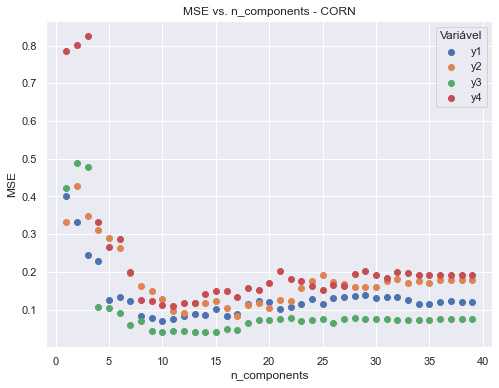

In [112]:
import warnings
warnings.filterwarnings('ignore')

pls = [0]*100                                                     # Inicia vetor com PLS de 1 a 100 componentes
mse = [0]*100                                                     # Inicia vetor de erro para guardar cada um dos erros da regressão PLS

for i in range(4):
    for n in range (1,100):                                              # Loop para calcular o erro para cada número de componentes

        pls[n] = PLSRegression(n_components=n)                           # Instancia o modelo PLS com n componentes
        pls[n].fit(X_train, y_train[i])                                  # Faz a regressão
        mse[n] = mean_squared_error(y_test[i], pls[n].predict(X_test))   # Calcula o erro   
    mse[0] = mse[1]                                                      # tratamento para evitar o erro na hora de avaliar o mínimo MSE


    sns.set(rc={'figure.figsize':(8,6)})                              # Define o tamanho e parâmetros da imagem
    ax = plt.scatter(range(1,40), mse[1:40])                          # Plota o gráfico de erro
    plt.title('MSE vs. n_components - CORN')                          # Define o título do gráfico  
    plt.xlabel('n_components')                                        # Define o título do eixo x
    plt.ylabel('MSE')                                                 # Define o título do eixo y
    plt.legend(title='Variável', loc='upper right', labels=['y1', 'y2', 'y3', 'y4'])
    

    # Printa o número de componentes e o erro mínimo
    print('MSE mínimo: {0:.2f} foi atingido com n_components = {1} para a variável de saída n{2}'.format(min(mse[1:40]), mse.index(min(mse[1:40]))+1, i+1))
    print('R2 score da regressão com {0} componentes para a variável de saida n{1}: {2:.2f}'.format(mse.index(min(mse[1:40]))+1, i+1, r2_score(y_test[i], pls[mse.index(min(mse[1:40]))+1].predict(X_test))))
    print('\n')